In [3]:
# Hyperparameter tuning
import torch
import pandas as pd
from py2neo import Graph
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Connect to the Neo4j database
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

# EXPORT GRAPH DATA FROM NEO4J
nodes_query = """
MATCH (n) 
RETURN id(n) AS node_id, n.percentage_neuronal AS percentage_neuronal, n.percentage_other AS percentage_other, n.median_signal AS median_signal, n.img_name as img_name
"""
nodes_df = pd.DataFrame(graph.run(nodes_query).data())

edges_query = """
MATCH (n)-[r]->(m) 
RETURN id(n) AS source, id(m) AS target
"""
edges_df = pd.DataFrame(graph.run(edges_query).data())

# Convert percentage columns to numeric
nodes_df['percentage_neuronal'] = pd.to_numeric(nodes_df['percentage_neuronal'], errors='coerce')
nodes_df['percentage_other'] = pd.to_numeric(nodes_df['percentage_other'], errors='coerce')

# Create binary labels: 0 and 1
nodes_df['label'] = nodes_df.apply(lambda row: 1 if row['percentage_other'] == 100 else (0 if row['percentage_neuronal'] == 100 else -1), axis=1)

# Assuming nodes_df has an 'img_name' column
# One-hot encode the 'img_name' column
encoder = OneHotEncoder(sparse=False)
img_name_encoded = encoder.fit_transform(nodes_df[['img_name']])

img_name_tensor = torch.tensor(img_name_encoded, dtype=torch.float)

# Create a NetworkX graph from edges_df
G = nx.from_pandas_edgelist(edges_df, 'source', 'target')

# Add node features (category percentages and median_signal)
for index, row in nodes_df.iterrows():
    G.nodes[row['node_id']]['percentage_neuronal'] = row['percentage_neuronal']
    G.nodes[row['node_id']]['percentage_other'] = row['percentage_other']
    G.nodes[row['node_id']]['median_signal'] = row['median_signal']
    G.nodes[row['node_id']]['img_name'] = row['img_name']


# Convert NetworkX graph to PyTorch Geometric graph
data = from_networkx(G)

# Step 1: Extract node IDs and their median_signal values
node_ids = list(G.nodes)
median_signal_values = []
valid_node_ids = []

for node_id in node_ids:
    signal_value = G.nodes[node_id].get('median_signal', float('nan'))
    try:
        signal_value = float(signal_value)
    except (ValueError, TypeError):
        signal_value = float('nan')
    
    median_signal_values.append(signal_value)
    valid_node_ids.append(node_id)
    
median_signal_tensor = torch.tensor(median_signal_values, dtype=torch.float).view(-1, 1)

# Step 2: Assign the feature 'median_signal' with or without imaging name encoding to all nodes
#data.x = torch.tensor(median_signal_values, dtype=torch.float).view(-1, 1)
data.x = torch.cat([median_signal_tensor, img_name_tensor], dim=1)


# Step 3: Align the labels with the node IDs
label_dict = dict(zip(nodes_df['node_id'], nodes_df['label']))
labels = [label_dict.get(node_id, -1) for node_id in valid_node_ids]
data.y = torch.tensor(labels, dtype=torch.long)

# Step 4: Create masks for training and testing
# Mask for labeled nodes
train_mask = data.y != -1

# Randomly split the labeled nodes into training and test sets
num_train = int(0.7 * train_mask.sum().item())  # 70% for training
train_indices = np.random.choice(np.where(train_mask.numpy())[0], size=num_train, replace=False)
test_indices = np.setdiff1d(np.where(train_mask.numpy())[0], train_indices)

# Create masks
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True

data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[test_indices] = True

# Ensure sizes match
print("Data size:")
print(f"Nodes: {data.num_nodes}")
print(f"Features shape: {data.x.shape}")
print(f"Labels shape: {data.y.shape}")

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model with the new input_dim (e.g., 1 for median_signal + 5 for img_name categories)
input_dim = median_signal_tensor.shape[1] + img_name_tensor.shape[1]  # For example, 6
model = GCN(input_dim=input_dim, hidden_dim=16, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Function to train and evaluate the model for given hyperparameters
def train_and_evaluate(hidden_dim, learning_rate, num_epochs=200):
    model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    # Evaluate on the test set
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    accuracy = int(correct) / int(data.test_mask.sum())
    
    return accuracy

import optuna

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 8, 64)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    
    accuracy = train_and_evaluate(hidden_dim, learning_rate)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(study.best_params)

[I 2024-11-18 15:35:22,249] A new study created in memory with name: no-name-6c791609-56a3-43e0-9b78-8292f5d226b6


Data size:
Nodes: 1143
Features shape: torch.Size([1143, 10])
Labels shape: torch.Size([1143])


[I 2024-11-18 15:35:25,852] Trial 0 finished with value: 0.8988326848249028 and parameters: {'hidden_dim': 19, 'learning_rate': 0.03624822109157711}. Best is trial 0 with value: 0.8988326848249028.
[I 2024-11-18 15:35:29,854] Trial 1 finished with value: 0.8793774319066148 and parameters: {'hidden_dim': 44, 'learning_rate': 0.04120624952415128}. Best is trial 0 with value: 0.8988326848249028.
[I 2024-11-18 15:35:33,816] Trial 2 finished with value: 0.8638132295719845 and parameters: {'hidden_dim': 48, 'learning_rate': 0.0007979842141924392}. Best is trial 0 with value: 0.8988326848249028.
[I 2024-11-18 15:35:37,477] Trial 3 finished with value: 0.8638132295719845 and parameters: {'hidden_dim': 28, 'learning_rate': 0.00018438785604479754}. Best is trial 0 with value: 0.8988326848249028.
[I 2024-11-18 15:35:41,292] Trial 4 finished with value: 0.8754863813229572 and parameters: {'hidden_dim': 34, 'learning_rate': 0.06051597851128314}. Best is trial 0 with value: 0.8988326848249028.
[I 20

[I 2024-11-18 15:38:15,237] Trial 41 finished with value: 0.8754863813229572 and parameters: {'hidden_dim': 35, 'learning_rate': 0.07293313152758336}. Best is trial 31 with value: 0.9299610894941635.
[I 2024-11-18 15:38:19,403] Trial 42 finished with value: 0.9221789883268483 and parameters: {'hidden_dim': 45, 'learning_rate': 0.08327991484187974}. Best is trial 31 with value: 0.9299610894941635.
[I 2024-11-18 15:38:23,565] Trial 43 finished with value: 0.867704280155642 and parameters: {'hidden_dim': 29, 'learning_rate': 0.050786196807800714}. Best is trial 31 with value: 0.9299610894941635.
[I 2024-11-18 15:38:27,453] Trial 44 finished with value: 0.8715953307392996 and parameters: {'hidden_dim': 26, 'learning_rate': 0.03106673388999246}. Best is trial 31 with value: 0.9299610894941635.
[I 2024-11-18 15:38:31,142] Trial 45 finished with value: 0.867704280155642 and parameters: {'hidden_dim': 21, 'learning_rate': 0.04735419590810377}. Best is trial 31 with value: 0.9299610894941635.
[

{'hidden_dim': 38, 'learning_rate': 0.0887470180738899}


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


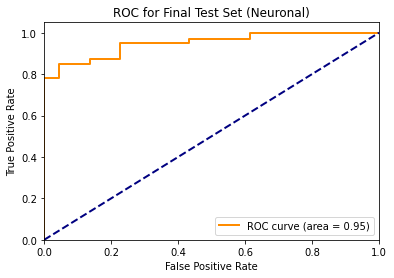

In [4]:
# HYPERPARAMETER TUNED + TEST SET + CV 
import torch
import pandas as pd
from py2neo import Graph
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

# EXPORT GRAPH DATA FROM NEO4J
nodes_query = """
MATCH (n) 
RETURN id(n) AS node_id, n.percentage_neuronal AS percentage_neuronal, n.percentage_other AS percentage_other, n.median_signal AS median_signal, n.img_name as img_name
"""
nodes_df = pd.DataFrame(graph.run(nodes_query).data())

edges_query = """
MATCH (n)-[r]->(m) 
RETURN id(n) AS source, id(m) AS target
"""
edges_df = pd.DataFrame(graph.run(edges_query).data())

# Convert percentage columns to numeric
nodes_df['percentage_neuronal'] = pd.to_numeric(nodes_df['percentage_neuronal'], errors='coerce')
nodes_df['percentage_other'] = pd.to_numeric(nodes_df['percentage_other'], errors='coerce')

# Create binary labels: 0 and 1
nodes_df['label'] = nodes_df.apply(lambda row: 1 if row['percentage_other'] == 100 else (0 if row['percentage_neuronal'] == 100 else -1), axis=1)

# One-hot encode the 'img_name' column
encoder = OneHotEncoder(sparse=False)
img_name_encoded = encoder.fit_transform(nodes_df[['img_name']])
img_name_tensor = torch.tensor(img_name_encoded, dtype=torch.float)

# Create a NetworkX graph from edges_df
G = nx.from_pandas_edgelist(edges_df, 'source', 'target')

# Add node features (category percentages and median_signal)
for index, row in nodes_df.iterrows():
    G.nodes[row['node_id']]['percentage_neuronal'] = row['percentage_neuronal']
    G.nodes[row['node_id']]['percentage_other'] = row['percentage_other']
    G.nodes[row['node_id']]['median_signal'] = row['median_signal']
    G.nodes[row['node_id']]['img_name'] = row['img_name']

# Convert NetworkX graph to PyTorch Geometric graph
data = from_networkx(G)

# Extract node IDs and their median_signal values
node_ids = list(G.nodes)
median_signal_values = []
valid_node_ids = []

for node_id in node_ids:
    signal_value = G.nodes[node_id].get('median_signal', float('nan'))
    try:
        signal_value = float(signal_value)
    except (ValueError, TypeError):
        signal_value = float('nan')
    
    median_signal_values.append(signal_value)
    valid_node_ids.append(node_id)

median_signal_tensor = torch.tensor(median_signal_values, dtype=torch.float).view(-1, 1)

# Combine median_signal and img_name features into data.x
data.x = torch.cat([median_signal_tensor, img_name_tensor], dim=1)

# Align the labels with the node IDs
label_dict = dict(zip(nodes_df['node_id'], nodes_df['label']))
labels = [label_dict.get(node_id, -1) for node_id in valid_node_ids]
data.y = torch.tensor(labels, dtype=torch.long)

# Create a valid mask for nodes with valid labels (i.e., label != -1)
valid_mask = data.y != -1

# Step 1: Split the data into training and a final test set (30% for test set)
train_idx, final_test_idx = train_test_split(np.where(valid_mask)[0], test_size=0.3, random_state=42)

# Update valid_mask to exclude final test set nodes
valid_mask[final_test_idx] = False

# Cross-validation setup
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True)
fold_results = []

# Define GCN model with optimized hyperparameters
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Step 2: Cross-validation on the training set
all_true_labels = []
all_pred_probs = []

for fold, (train_idx_cv, test_idx_cv) in enumerate(kf.split(np.where(valid_mask)[0])):  # Only split valid nodes
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Create train and test masks for this fold, applying the valid_mask
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

    # Set train and test masks to valid indices
    valid_indices = np.where(valid_mask.numpy())[0]
    data.train_mask[valid_indices[train_idx_cv]] = True
    data.test_mask[valid_indices[test_idx_cv]] = True

    # Initialize model and optimizer for each fold
    input_dim = data.x.shape[1]
    model = GCN(input_dim=input_dim, hidden_dim=38, output_dim=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0887470180738899)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Training loop for each fold
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
    # Evaluate model on the test set of the fold
    model.eval()
    out = model(data)
    probas = torch.exp(out)[:, 1].detach().numpy()  # Convert log-softmax to probabilities
    
    # Store true labels and predicted probabilities for this fold
    all_true_labels.extend(data.y[data.test_mask].numpy())
    all_pred_probs.extend(probas[data.test_mask])

# Step 3: Train the model on the full training set (excluding the final test set)
input_dim = data.x.shape[1]
model = GCN(input_dim=input_dim, hidden_dim=38, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0887470180738899)
loss_fn = torch.nn.CrossEntropyLoss()

# Set the train mask for the entire training set
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True

# Training loop for the full training set
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Step 4: Evaluate on the final test set
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[final_test_idx] = True

# Evaluate the model on the final test set
model.eval()
out = model(data)
probas = torch.exp(out)[:, 1].detach().numpy()  # Convert log-softmax to probabilities

# Get true labels and predicted probabilities for the final test set
true_labels = data.y[data.test_mask].numpy()
pred_probs = probas[data.test_mask]

# Compute ROC curve and AUC for the final test set
fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve for the final test set
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Final Test Set (Neuronal)')
plt.legend(loc="lower right")
plt.show()
